# STOCK PRICING PREDICTION

In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

LOAD DATASET

In [2]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

xy = np.loadtxt('data/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1] # REVERSE ORDER (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]
print ("SHAPE OF X IS %s" % (x.shape,))
print ("SHAPE OF Y IS %s" % (y.shape,))

SHAPE OF X IS (732, 5)
SHAPE OF Y IS (732, 1)


# DATASET HAS FIVE ITEMS

***OPEN / HIGH / LOW / VOLUME / CLOSE***

***OBJECTIVE IS TO PREDICT 'CLOSE' GIVEN 7 PREVIOUS ITEMS***

# BUILD A DATASET

In [3]:
timesteps = seq_length = 7
data_dim = 5
dataX, dataY = [], []

for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]
    dataX.append(_x)
    dataY.append(_y)
    if i == 0:
        print(" [INPUT]\n%s \n   =>\n [OUTPUT] \n%s" % (_x, _y))

print ()
print ("TYPE   OF    'dataX' IS [%s]." % (type(dataX)))
print ("LENGTH OF    'dataX' IS [%d]." % (len(dataX)))
print ("LENGTH OF 'dataX[0]' IS [%d]." % (len(dataX[0])))

print ()
print ("TYPE   OF    'dataY' IS [%s]." % (type(dataY)))
print ("LENGTH OF    'dataY' IS [%d]." % (len(dataY)))
print ("LENGTH OF 'dataY[0]' IS [%d]." % (len(dataY[0])))

 [INPUT]
[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] 
   =>
 [OUTPUT] 
[0.13289962]

TYPE   OF    'dataX' IS [<class 'list'>].
LENGTH OF    'dataX' IS [725].
LENGTH OF 'dataX[0]' IS [7].

TYPE   OF    'dataY' IS [<class 'list'>].
LENGTH OF    'dataY' IS [725].
LENGTH OF 'dataY[0]' IS [1].


# SPLIT TRAIN (70%) AND TEST (30%)

In [4]:
def print_np(_name, _x):
    print("TYPE  OF [%s] is [%s]" % (_name, type(_x)))
    print("SHAPE OF [%s] is %s" % (_name, _x.shape,))

In [5]:
train_size = int(len(dataY) * 0.7)
test_size  = len(dataY) - train_size
trainX = torch.tensor(dataX[0:train_size], dtype=torch.float)
trainY = torch.tensor(dataY[0:train_size], dtype=torch.float)
testX  = torch.tensor(dataX[train_size:len(dataX)], dtype=torch.float)
testY  = torch.tensor(dataY[train_size:len(dataY)], dtype=torch.float)
print_np('trainX', trainX)
print_np('trainY', trainY)
print_np('testX', testX)
print_np('testY', testY)

TYPE  OF [trainX] is [<class 'torch.Tensor'>]
SHAPE OF [trainX] is torch.Size([507, 7, 5])
TYPE  OF [trainY] is [<class 'torch.Tensor'>]
SHAPE OF [trainY] is torch.Size([507, 1])
TYPE  OF [testX] is [<class 'torch.Tensor'>]
SHAPE OF [testX] is torch.Size([218, 7, 5])
TYPE  OF [testY] is [<class 'torch.Tensor'>]
SHAPE OF [testY] is torch.Size([218, 1])


# DEFINE MODEL

In [6]:
class StockRNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=n_hidden)
        self.W = nn.Parameter(torch.randn([n_hidden, output_size]).type(torch.float))
        self.b = nn.Parameter(torch.randn([output_size]).type(torch.float))
        
    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        print (X.shape, hidden.shape)
        outputs, hidden = self.rnn(X, hidden)
        outputs = outputs[-1] # 최종 예측 Hidden Layer
        model = torch.mm(outputs, self.W) + self.b # 최종 예측 출력 층
        return model

# DEFINE PARAMETERS

In [7]:
hidden_dim   = 10
output_dim   = 1
learning_rate = 0.01
iterations   = 500

batch_size = len(trainX)

model = StockRNN(input_size=data_dim, n_hidden=hidden_dim, output_size=output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# TRAIN

In [8]:
losses = []

model.train()
for epoch in range(iterations):
    hidden = torch.zeros(1, batch_size, hidden_dim, requires_grad=True)
    output = model(hidden, trainX)
    loss = criterion(output, trainY)
    
    losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'Loss =', '{:.6f}'.format(loss))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print ('OPTIMIZATION FINISHED')

torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 

torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 

torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 5]) torch.Size([1, 507, 10])
torch.Size([7, 507, 

# PLOT LOSS

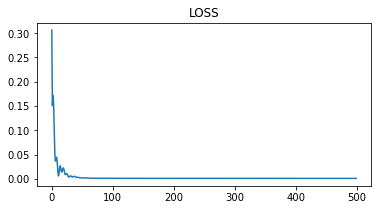

In [9]:
plt.figure(figsize=(6,3))
plt.plot(losses)
plt.title('LOSS')
plt.show()

# TEST

In [10]:
model.eval()

hidden = torch.zeros(1, len(testX), hidden_dim, requires_grad=False)
predict = model(hidden, testX)
rmse = F.mse_loss(predict, testY)

print_np('testX', testX)
print_np('test_predict', predict)
print("RMSE: {}".format(rmse))

torch.Size([7, 218, 5]) torch.Size([1, 218, 10])
TYPE  OF [testX] is [<class 'torch.Tensor'>]
SHAPE OF [testX] is torch.Size([218, 7, 5])
TYPE  OF [test_predict] is [<class 'torch.Tensor'>]
SHAPE OF [test_predict] is torch.Size([218, 1])
RMSE: 0.0007043692166917026


# PLOT PREDICTIONS

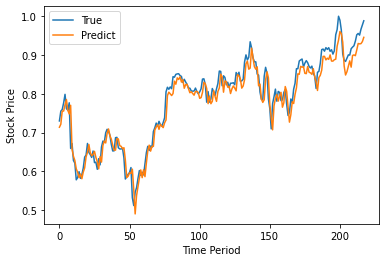

In [11]:
plt.plot(testY.data)
plt.plot(predict.data)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(['True', 'Predict'])
plt.show()